## MNIST Dataset: Neural Network, Convolutional Layer, Auto-Encoder

The purpose of this notebook is to investigate the MNIST dataset of handwritten digits. We will play with the Tensorflow library, implementing Neural Network, Convolutional Layer and Auto-Encoder

*This notebook is inspired from an assignment of the course **DAT405 Introduction to Data Science and AI, 2021**, taken when I was studying at Chalmers University of Technology*. 


First, we will import all the needed libraries.

In [2]:
# Importing the libraries
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Part 1: Preprocessing

Below is the preprocessing. All the comments are made directly in the code.

In [ ]:
# Hyper-parameters data-loading and formatting
batch_size = 128
num_classes = 10 # Representing the number 0-9
epochs = 10

# Dimensions of the images in pixel x pixel
img_rows, img_cols = 28, 28

In [ ]:
# Loading the data from the internet
(x_train, lbl_train), (x_test, lbl_test) = mnist.load_data()

In [ ]:
# Checking that we have 60000 samples of pictures of resolution 28x28 of numbers 0-9
x_train.shape

(60000, 28, 28)

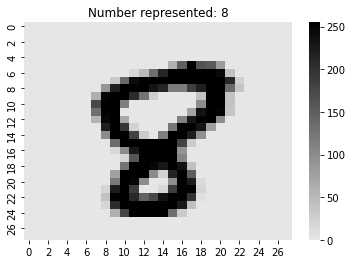

In [ ]:
# Here, we can draw a random number to see if the data loaded is correct
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)

# Choosing a random index
index_to_access = np.random.randint(len(x_train))

# Plotting the heat map
ax = plt.axes()
sns.heatmap(x_train[index_to_access], cmap=cmap, ax=ax)

# Giving a title to check if the labels are correct
ax.set_title('Number represented: ' + str(lbl_train[index_to_access]))
plt.show()

In [ ]:
# Now we reshape the data according to the format required by keras (either channel first or last)
if K.image_data_format() == 'channels_first': # It is 'channel_last' so the else will work
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
# We can check that now each x_train number is in the shape of 60000 arrays of 28x28x1 and not anymore a matrices 
x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).shape

(60000, 28, 28, 1)

In [ ]:
# Necessary steps to later divide (normalize) the data to a float number between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the data
x_train /= 255
x_test /= 255

# Converting the label vector of integers to a binary class matrix
y_train = tf.keras.utils.to_categorical(lbl_train, num_classes)
y_test = tf.keras.utils.to_categorical(lbl_test, num_classes)

In [ ]:
# As expected, the shape is 60000 (number of samples)
y_train.shape

(60000, 10)

In [ ]:
# For example, the first label is number of train data (60000) x number of labels numbers 0-9 (10)
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## Part 2: Neural Network implementation

### A.

*How many layers does the network in the notebook have? How many neurons does each layer have? What activation functions and why are these appropriate for this application? What is the total number of parameters for the network? Why does the input and output layers have the dimensions they have?*

We have 4 layers: 1 input layer (which may not be accounted in the total number of layers), 2 hidden layers, 1 output layer.

The input layer has 784 (28x28) neurons, representing all the pixels of the image.
The hidden layers have both 64 neurons each as written in model.add(...).
The output layer has 10 neurons representing the 10 possible numbers (0-9).

The activation function used for the hidden layers is the **Rectified Linear Unit** (ReLU). This is because some recent work on image recognition ([What is the Best Multi-Stage Architecture for Object Recognition?](http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf)) has found considerable benefit in using rectified linear units through much of the network.
The activation function used for the output layer is the **Softmax**. This is because it is often used as the last activation function of a neural network to normalize the output of a network to a probability distribution over predicted output classes as the output from the softmax layer can be thought of as a probability distribution. In many problems, such as this one, it's convenient to be able to interpret the output activation as the network's estimate of the probability that the correct output is j. 

The total number of parameters (=weights) for the network is equal to the sum all of the neurons in the hidden layers and the output layer, so 64+64+num_classes(10)=138.

The input layer dimension (784) is the same as the number of inputs (28x28 pixel matrix), while the output layer dimension (10) is the same as the dimension of the binary matrix representing the number 0-9.

### B.

*What loss-function is used to train the network? What is the functional form (mathematical 
expression) of the loss function? and how should we interpret it? Why is it appropriate for the 
problem at hand?*

The used loss-function used is the *cross-entropy*. 

The mathematical expression is: $C = - \frac{1}{n}\sum_{x} [y$ln$a + (1-y)$ln$(1-a)]$, where *n* is the total number of items of training data, the sum is over all training inputs, *x*, and *y* is the corresponding desired output.

Two properties in particular make it reasonable to interpret the cross-entropy as a cost function: 
- It's non-negative, that is, $C > 0$. To see this, notice that: (a) all the individual terms in the sum are negative, since both logarithms are of numbers in the range 0 to 1; and (b) there is a minus sign out the front of the sum. 
- If the neuron's actual output is close to the desired output for all training inputs, x, then the cross-entropy will be close to zero. To see this, suppose for example that y = 0 and a ≈ 0 for some input x. This is a case when the neuron is doing a good job on that input. We see that the first term in the expression for the cost vanishes, since y = 0, while the second term is just  −ln(1 − a) ≈ 0. A similar analysis holds when y = 1 and a ≈ 1. And so the contribution to the cost will be low provided the actual output is close to the desired output.

The cross-entropy loss-function is appropriate since it avoids the learning slowdown that we could otherwise get with the quadratic cost function.

### C.

We are now going to train the network for 10 epochs and then plot the training and validation accuracy for each epoch. 

Firstly, we are going to define our network.

In [ ]:
# Define model
model = Sequential()

# Defining the characteristics of the model
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compiling the model with a learning rate, requesting as ouput the value of the loss function and the accuracy
model.compile(loss=tf.keras.losses.categorical_crossentropy,
            optimizer=tf.keras.optimizers.SGD(learning_rate = 0.1),
            metrics=['accuracy'])

Then, we are going to train our network for 10 epochs.

In [ ]:
# Training the model with the data
fit_info = model.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=0,
           validation_data=(x_test, y_test))

# Computing the results of the training
score = model.evaluate(x_test, y_test, verbose=0)

We can now print and plot the **results** of the trained network.

In [ ]:
# Printing the results of the training
print('Test loss: %.4f, Test accuracy %.4f' % (score[0], score[1]))

Test loss: 0.0881, Test accuracy 0.9722


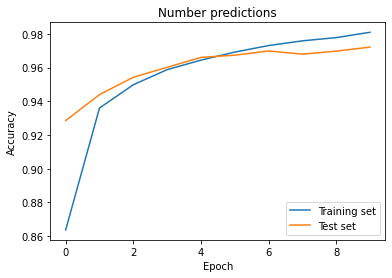

In [ ]:
# Things to plot
plt.plot(fit_info.history['accuracy'])
plt.plot(fit_info.history['val_accuracy'])

# Labels, title and legend
plt.title('Number predictions')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='lower right')

# Plotting
plt.show()

### D.

We are now going to implement a network where the hidden layers have 300 and 500 neurons. We are going to train for 40 epochs. We will use and experiment 5 different values of weight decay (L2 regularization), from 1e-6 to 1e-2. We are going to train the network 3 times each and then plot it along with the standard deviation.

Firstly, we are going to train a normal network *without* regularization to see the results. This will allow us to have a first look at how the network will behave with the new hidden layers.

In [ ]:
epochs = 40

In [ ]:
# Define model n2
model = Sequential()

# Defining the characteristics of the model
model.add(Flatten())
model.add(Dense(500, activation = 'relu'))
model.add(Dense(300, activation = 'relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compiling the model with a learning rate, requesting as ouput the value of the loss function and the accuracy
model.compile(loss=tf.keras.losses.categorical_crossentropy,
            optimizer=tf.keras.optimizers.SGD(learning_rate = 0.1),
            metrics=['accuracy'])

In [ ]:
# Training the model with the data
fit_info = model.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=0,
           validation_data=(x_test, y_test))

# Computing the results of the training
score = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
# Printing the results of the training
print('Test loss: %.4f, Test accuracy %.4f' % (score[0], score[1]))

Test loss: 0.0653, Test accuracy 0.9811


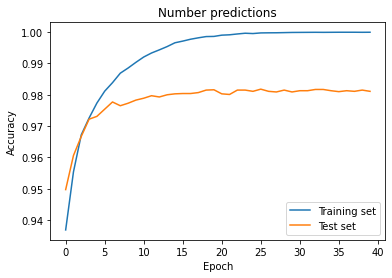

In [ ]:
# Things to plot
plt.plot(fit_info.history['accuracy'])
plt.plot(fit_info.history['val_accuracy'])

# Labels, title and legend
plt.title('Number predictions')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='lower right')

# Plotting
plt.show()

As we can clearly see, the network rapidly hits a plateau in the test set, indicating overfitting of the training data. In fact, after about 30 epochs we even reach 100% training accuracy, which confirms overfitting.

We can now use L2 regularization to see if we can avoid this problem. We expect to see the curves of test and training closer as a proof of *not* overfitting anymore.

In [ ]:
# Settings for the next train
weights_decay = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
number_epochs = 40
learning_rate_chosen = 0.1

The code will be the same, except we loop 3 times over each of the chosen weights. Then, we store everything in a dataframe.

In [ ]:
# Creating the empty dataframe to store all the training accuracy data
df_fit = pd.DataFrame(columns=['epoch', 'value', 'type', 'weight_decay'])

# Loop over the weights, 3 times each
for weight_decay in weights_decay:
    for _ in range(0,3):
        # Define model
        model = Sequential()

        # Defining the weight decay as L2
        tf.keras.regularizers.l2(l2=weight_decay)

        # Defining the characteristics of the model
        model.add(Flatten())
        model.add(Dense(500, activation = 'relu', kernel_regularizer='l2'))
        model.add(Dense(300, activation = 'relu', kernel_regularizer='l2'))
        model.add(Dense(num_classes, activation='softmax'))

        # Compiling the model with a learning rate, requesting as ouput the value of the loss function and the accuracy
        model.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.SGD(learning_rate = learning_rate_chosen = 0.1),
                    metrics=['accuracy'])

        # Training the model with the data
        fit_info = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=number_epochs,
                   verbose=0,
                   validation_data=(x_test, y_test))

        # Computing the results of the training
        score = model.evaluate(x_test, y_test, verbose=1)

        # Creating arrays to then append in the dataframe to store all the accuracy data
        temp_array = [np.array(range(0, number_epochs)),
                      np.transpose(fit_info.history['accuracy']),
                      np.array(['accuracy']*number_epochs),
                      np.array([weight_decay]*number_epochs)] 
        df_temp = pd.DataFrame(np.array(temp_array).T, columns=['epoch', 'value', 'type', 'weight_decay'])
        df_fit = df_fit.append(df_temp)    
        temp_array = [np.array(range(0, number_epochs)),
                      np.transpose(fit_info.history['val_accuracy']), 
                      np.array(['val_accuracy']*number_epochs),
                      np.array([weight_decay]*number_epochs)] 
        df_temp = pd.DataFrame(np.array(temp_array).T, columns=['epoch', 'value', 'type', 'weight_decay'])
        df_fit = df_fit.append(df_temp)  

313/313 [==============================] - 1s 4ms/step - loss: 0.2711 - accuracy: 0.9633


In [ ]:
# Post processing the dataframe
# Resetting index
df_fit.index = range(0,len(df_fit)) 

# Making the columns numeric
df_fit["value"] = pd.to_numeric(df_fit["value"])
df_fit["weight_decay"] = pd.to_numeric(df_fit["weight_decay"])

If the code has already been run, we can directly read the data from the relative *csv*.

In [ ]:
try:
    # Check how the dataframe looks
    df_fit.head
# catch when it hasn't even been defined
except NameError:
    # Reading data from the csv if we did not run the code
    df_fit = pd.read_csv('fit.csv')
df_fit.head

<bound method NDFrame.head of       epoch     value          type  weight_decay
0         0  0.879167      accuracy      0.000001
1         1  0.920967      accuracy      0.000001
2         2  0.929933      accuracy      0.000001
3         3  0.937317      accuracy      0.000001
4         4  0.941833      accuracy      0.000001
...     ...       ...           ...           ...
1195     35  0.951300  val_accuracy      0.010000
1196     36  0.958700  val_accuracy      0.010000
1197     37  0.935900  val_accuracy      0.010000
1198     38  0.962800  val_accuracy      0.010000
1199     39  0.960800  val_accuracy      0.010000

[1200 rows x 4 columns]>

We will now plot the results in different axis depending on the weight decay chosen. It will also be shown the standard deviation as a colored area around the line.

In [ ]:
# Setting theme for plots
sns.set_theme(style="ticks")
# Define the palette as a list to specify exact values
palette = sns.color_palette('tab10',2)

(0.875, 1.0)

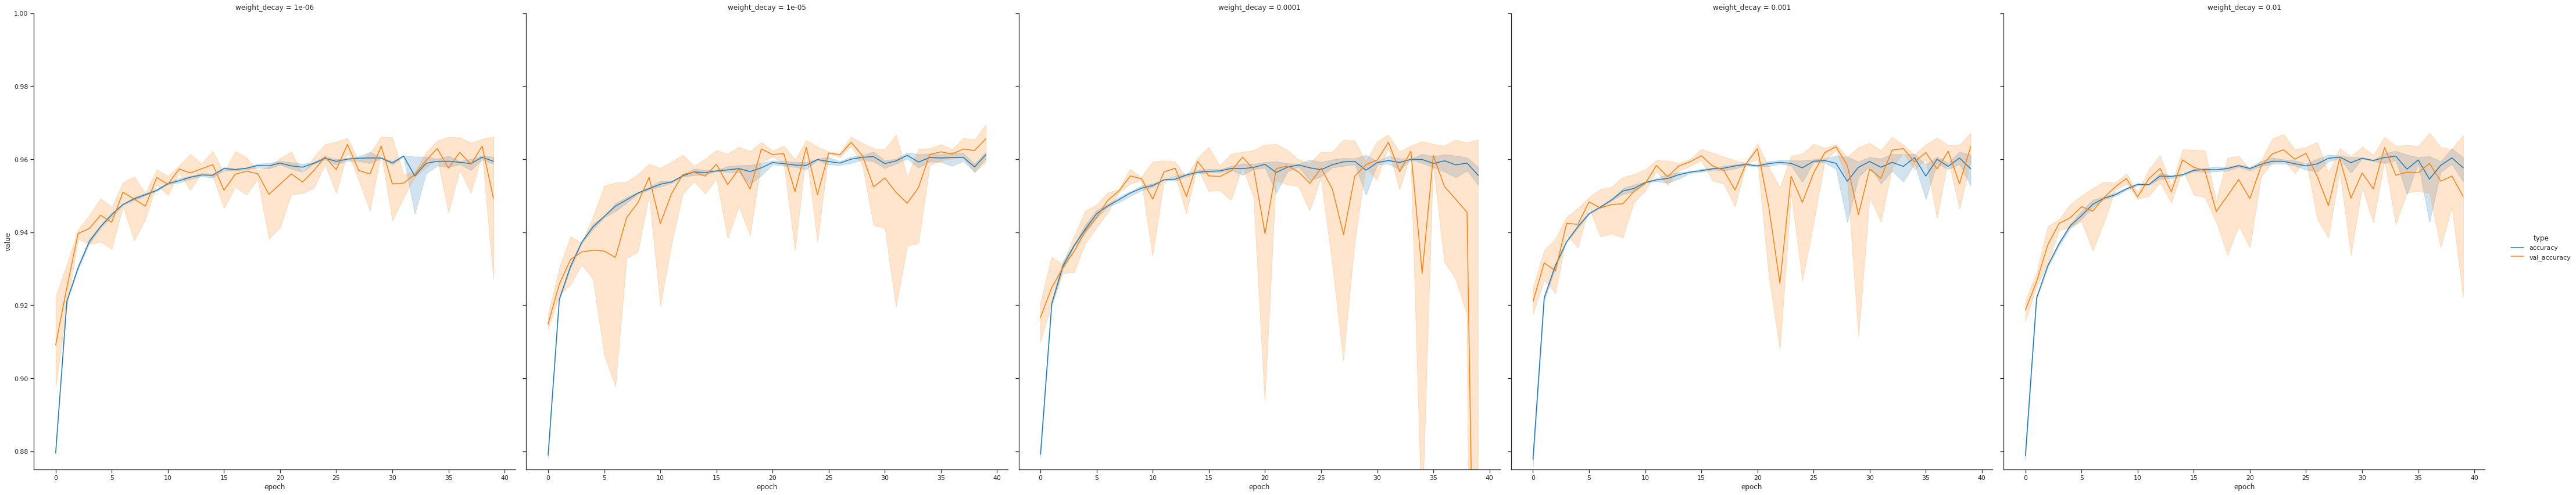

In [ ]:
# Plot the lines on two facets
sns.relplot(
    data=df_fit,
    x="epoch", y="value",
    col="weight_decay", hue="type",
    kind="line", palette=palette,
    height=12, aspect=1
)
plt.ylim(0.875, 1)

In [ ]:
print('The best accuracy for the validation dataset is: ', max(df_fit[df_fit['type']=='val_accuracy']['value']))

The best accuracy for the validation dataset is:  0.9695000052452089


As expected, we got validation and test curves that are closer showing that overfitting was resolved. Furthermore, we can see that using L2 regularization introduces instability and noise in the accuracy. But, as we can see, the best accuracy we got for every run was 96.95%.  This is way lower than the one obtained before with the unregularized network (98.11%). It is not clear to us why this is happening. The fact that we could not tune the learning rate, the batch size and the epochs mean we are missing maybe the best behaviour that the regularization could have. 

We can now try to train again an unregularized network, but this time with *batch size* = 10, instead of 128. This should allow to have a better and more stable accuracy.

In [ ]:
batch_size=10

In [ ]:
# Define model n2
best_model = Sequential()

# Defining the characteristics of the model
best_model.add(Flatten())
best_model.add(Dense(500, activation = 'relu'))
best_model.add(Dense(300, activation = 'relu'))
best_model.add(Dense(num_classes, activation='softmax'))

# Compiling the model with a learning rate, requesting as ouput the value of the loss function and the accuracy
best_model.compile(loss=tf.keras.losses.categorical_crossentropy,
            optimizer=tf.keras.optimizers.SGD(learning_rate = 0.1),
            metrics=['accuracy'])

In [ ]:
# Training the model with the data
fit_info = best_model.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=0,
           validation_data=(x_test, y_test))

# Computing the results of the training
score = best_model.evaluate(x_test, y_test, verbose=0)

In [ ]:
try:
    # Check how the dataframe looks
    df_fit_unregulated.head
# catch when it hasn't even been defined
except NameError:
    # Reading data from the csv if we did not run the code
    df_fit_unregulated = pd.read_csv('fit_unregulated.csv')
df_fit_unregulated.head

<bound method NDFrame.head of     epoch     value          type
0       0  0.937833  training_set
1       1  0.973833  training_set
2       2  0.981667  training_set
3       3  0.987750  training_set
4       4  0.989550  training_set
..    ...       ...           ...
75     35  0.986900      test_set
76     36  0.987000      test_set
77     37  0.987000      test_set
78     38  0.987000      test_set
79     39  0.987000      test_set

[80 rows x 3 columns]>

(0.875, 1.01)

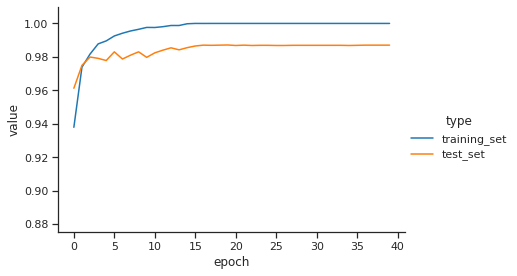

In [ ]:
# Plot the lines on two facets
sns.relplot(
    data=df_fit_unregulated,
    x="epoch", y="value", hue="type",
    kind="line", palette=palette,
    height=4, aspect=1.5
)
plt.ylim(0.875, 1.01)

In [ ]:
print('The best accuracy for the validation dataset is: ', max(df_fit_unregulated[df_fit_unregulated['type']=='test_set']['value']))

The best accuracy for the validation dataset is:  0.9871000051498412


As we can see, an **unregularized** network performed better than the regularized one, having an accuracy of 98.70%.  This is even higher than the results of Hamilton. Of course, we keep having the same problem of overfitting. This can be addressed with L2 regularization but, as we saw above, it yielded actually worse results even if removing the overfitting problem. Another way would be to introduce the technique of *dropout*. 

Either way, the results obtained by Hamilton may have been easily influenced by different learning rate, batch size and number of epochs. As our training used a fixed learning rate = 0.1 and batch size = 128 and epochs = 40, it may well be possible that a better results could be yielded with lower learning rates and batch sizes, while compensating with more epochs. This would, of course, require more computational power and time that (probably) Hilton had access to, more than us.

(19.0, 39.0)

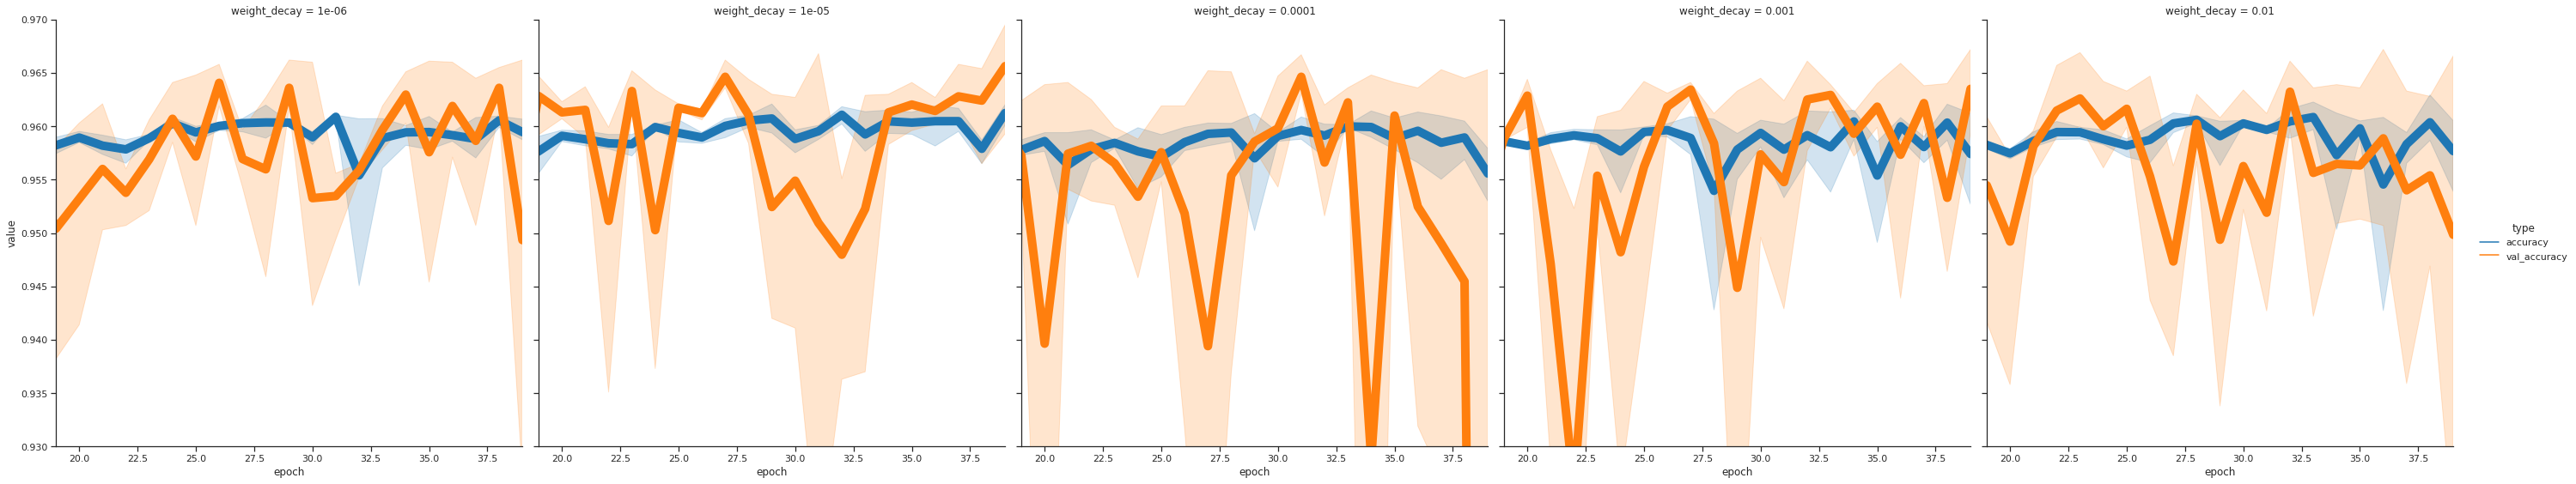

In [ ]:
# Plot the lines on two facets
sns.relplot(
    data=df_fit,
    x="epoch", y="value",
    col="weight_decay", hue="type",
    kind="line", palette=palette,
    height=8, aspect=1,
    linewidth=10
)
plt.ylim(0.93, 0.97)
plt.xlim(19, 39)

<AxesSubplot:xlabel='epoch', ylabel='value'>

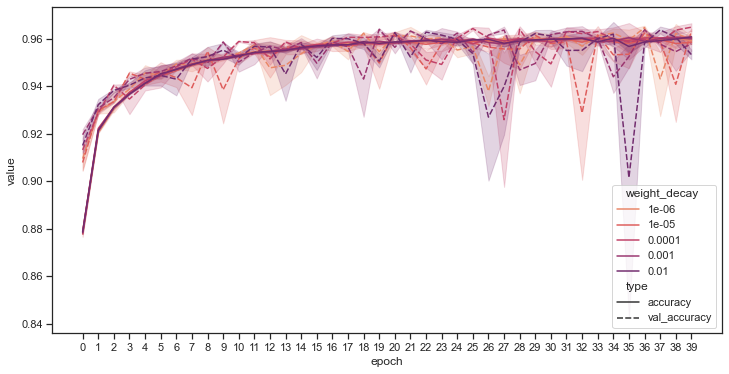

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_fit, 
             y='value', 
             x='epoch', 
             hue='weight_decay',
             palette=palette,
             style='type',
             err_style="band",
             ci=68)

# Part 3: Convolutional Layers


### 3.A

We can now try to improve our results through the use of convolutional layers. 

Our first 2 layers are Conv2D layers. These are convolution layers that will deal with our input images, which are seen as 2-dimensional matrices.

64 in the first layer and 32 in the second layer are the number of nodes in each layer. These numbers can vary, but in our case, 64 and 32 work well, so we will stick with this.

Kernel size is the size of the filter matrix for our convolution. So a kernel size of 3 means we will have a 3x3 filter matrix.

In [ ]:
#create model
model_conv = Sequential()
#add model layers
model_conv.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model_conv.add(Conv2D(32, kernel_size=3, activation='relu'))
model_conv.add(Flatten())
model_conv.add(Dense(500, activation = 'relu'))
model_conv.add(Dense(300, activation = 'relu'))
model_conv.add(Dense(10, activation='softmax'))

We will be using *adam* as our optmizer as it adjusts the learning rate throughout training.

In [ ]:
#compile model using accuracy to measure model performance
model_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

We will use a batch size of 500 and train for 7 epochs. This was a tradeoff as our computational power was limited. It would have been better to train on smaller batch sizes and having more epochs.

In [ ]:
#train the model
fit_conv_info = model_conv.fit(x_train, 
                          y_train,
                          batch_size=500,
                          verbose=1,
                          validation_data=(x_test, y_test), epochs=7)

Epoch 1/7
120/120 [==============================] - 40s 331ms/step - loss: 0.2357 - accuracy: 0.9284 - val_loss: 0.0532 - val_accuracy: 0.9826
Epoch 2/7
120/120 [==============================] - 41s 342ms/step - loss: 0.0477 - accuracy: 0.9851 - val_loss: 0.0421 - val_accuracy: 0.9877
Epoch 3/7
120/120 [==============================] - 41s 342ms/step - loss: 0.0270 - accuracy: 0.9916 - val_loss: 0.0355 - val_accuracy: 0.9879
Epoch 4/7
120/120 [==============================] - 41s 339ms/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.0349 - val_accuracy: 0.9887
Epoch 5/7
120/120 [==============================] - 41s 343ms/step - loss: 0.0113 - accuracy: 0.9964 - val_loss: 0.0325 - val_accuracy: 0.9897
Epoch 6/7
120/120 [==============================] - 41s 341ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0343 - val_accuracy: 0.9893
Epoch 7/7
120/120 [==============================] - 41s 341ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.0446 - val_accuracy:

In [ ]:
# Computing the results of the training
score = model_conv.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 3s 9ms/step - loss: 0.0446 - accuracy: 0.9883


The results are the best so far! We achieved an accuracy of 98.83%. 

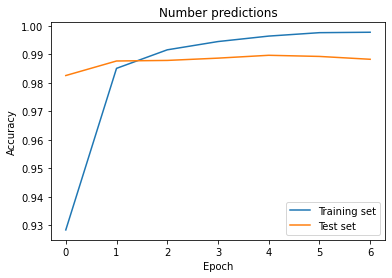

In [ ]:
# Things to plot
plt.plot(fit_conv_info.history['accuracy'])
plt.plot(fit_conv_info.history['val_accuracy'])

# Labels, title and legend
plt.title('Number predictions')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='lower right')

# Plotting
plt.show()

The graph shows how overfitting was starting to happen, since it looks like the test set hit a plateau while the training set kept increasing. With a smaller batch size and more epochs we could probably reach a stabe accuracy of 99%+. Furthermore, small tweaks in the neural network would help to do so as well. Unluckly, our computational power is limited and the amount of test that could be done were restricted. We are confident that with L2 regularization, we could maybe get better results as well.

### 3.B

The differences with a fully connected Neural Network and Convolutional Neural Network (CNN) mainly lie in the use of filters -or kernels- in the CNN.
In fact, not only weights of perceptrons are updated in CNN but also the values of these kernels that are applied on the whole input by convolution.
This means that the difference in training is based on the idea that fully connected network will work and train truly on the *inputs* while CNN will mainly train on *features* of the inputs.

The potential benefits of CNN for these application is that CNN will understand semantic meanings for each pixel and its surroundings. Since digits are characterized by specific shapes, this might be relevant to do so.
Moreover, classical multilayers perceptrons are not translation invariant, ie not biased by the pixel position, meaning if the input digit is not perfectly in the same position or a specific feature is shifted a tiny bit from most of the similar digits, the neural network will adapt its weights for that. CNN are not influenced by this. This also helps avoiding overfitting.


# Part 4: Autoencoders



# 4.A:

In this section, how the model works will be explained by having a look into data preparation and model definition. The role of the loss-function will be explained.

#### Data Loading and Preprocessing

As in the previous sections, the same MNIST dataset will be used. The libraries and the train and test sets are first imported.

In [ ]:
# Loads the training and test data sets (ignoring class labels)
(x_train, _), (x_test, _) = mnist.load_data()

# Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

In [ ]:
#Check of the dimensions
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

As before, the data is reshaped into vectors to allow the neural network to use these data as inputs.

In [ ]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train.shape, x_test.shape)

((60000, 784), (10000, 784))

### Simple Autoencoder
To reach its goal, the neural network model need to take the initial data as input and output. To define the level of compression we want to reach, the simple autoencoder works with one hidden layer (called encoder) that has the dimension desired for the compression.
Here, the compression ratio is 24.5, meaning the dimension of the hidden layer is 32 while the dimension of inputs and outputs are the data dimensions, ie 784.

In [ ]:
# input dimension = 784
input_dim = x_train.shape[1]
encoding_dim = 32

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

autoencoder = Sequential()
autoencoder.add(
    Dense(encoding_dim, input_shape=(input_dim,), activation='relu')
)
autoencoder.add(
    Dense(input_dim, activation='sigmoid')
)

autoencoder.summary()

Compression factor: 24.5
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_11 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


#### Encoder, Decoder and Autoencoder Model

The three models model are looked upon here, by extracting the hidden layer for the encoder and extracting the output layer for the decoder.

In [ ]:
input_img = Input(shape=(input_dim,))
encoder_layer = autoencoder.layers[0]
encoder = Model(input_img, encoder_layer(input_img))

encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                928       
Total params: 928
Trainable params: 928
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_img_decode = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[1]
decoder = Model(input_img_decode, decoder_layer(input_img_decode))

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 28)                924       
Total params: 924
Trainable params: 924
Non-trainable params: 0
_________________________________________________________________


A schematic of how the simple autoencoder network would work is drawn below. To avoid having a 784x32x784 3-layers network, a 10x4x10 is drawn to show proportions.

In [ ]:
import matplotlib.pyplot as plt

#Reference:
#https://gist.github.com/craffel/2d727968c3aaebd10359 

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

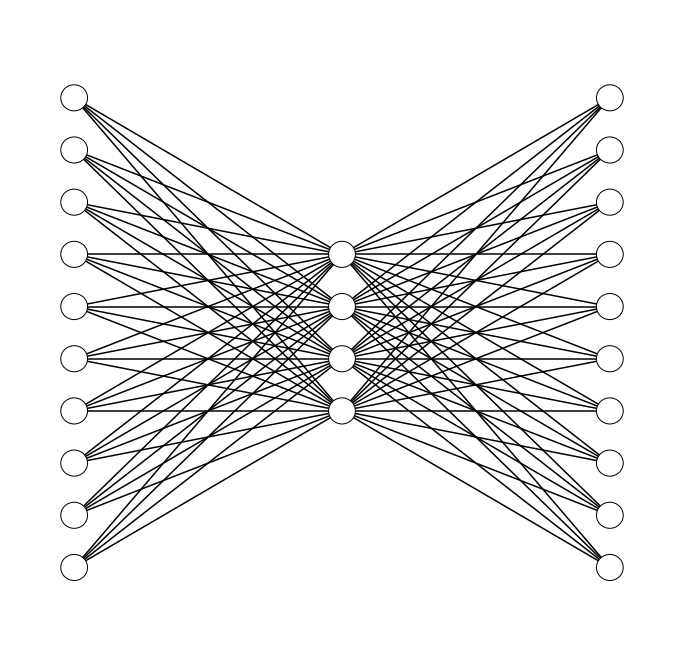

In [ ]:
#Plotting the schematic
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [10,4, 10])
fig.savefig('nn.png')

The repeat of `x_train` in `autoencoder.fit(x_train, x_train, ...)` implies that `x_train` is both the input and output, which is exactly what we want for image reconstruction in this auto-encoder.


The model is trained here. The training data will be iterated in batches of 256 in 50 epochs. [The Adam optimizer](https://arxiv.org/abs/1412.6980) and per-pixel binary [crossentropy] are used.


In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 4s 15ms/step - loss: 0.3849 - val_loss: 0.1913
Epoch 2/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1813 - val_loss: 0.1534
Epoch 3/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1492 - val_loss: 0.1330
Epoch 4/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1307 - val_loss: 0.1198
Epoch 5/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1188 - val_loss: 0.1111
Epoch 6/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1110 - val_loss: 0.1052
Epoch 7/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1054 - val_loss: 0.1014
Epoch 8/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1019 - val_loss: 0.0984
Epoch 9/50
235/235 [==============================] - 3s 13ms/step - loss: 0.0992 - val_loss: 0.0963
Epoch 10/50
235/235 [==============================] - 3s 13ms/step - loss: 0.0973 - val_lo

The model has been successfully trained based on the cross-entropy loss function. This loss function will compute an estimation of loss between the output and the input, ie the initial data and the reconstruction of this data - the deccoding of the initial data after encoding. 


10 samples will be checked to see how the encoding and decoding worked.

#### Plot the compressed images


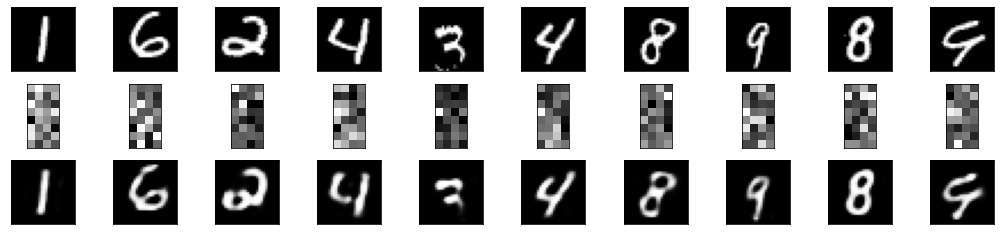

In [ ]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The reconstructed images are readable. However, the reconstructed images are quite lossy. You can see the digits clearly, but notice the loss in image quality.

## 4B: "Seasoned" data

The purpose of this section is to add some noise (here 'salt and pepper') and see if the auto encoder can still decode noisy images. 

In [ ]:
#import of the required library to add the noise
from skimage.util import random_noise

Let's plot an example of a noisy picture with 30% salt and pepper vs the original image. Throughout the whole study, the proportion of salt and pepper will stay equal (meaning 50% salt and 50% pepper).

Noisy picture with 30% noise


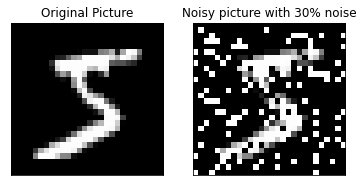

In [ ]:
#Noisy array with random 1(=salt) and 0(=pepper) values
noise_img = random_noise(x_train[0], mode='s&p',amount =0.3)

#Plotting the original picture
ax=plt.subplot(1,2,1)
plt.imshow(x_train[0].reshape(28, 28))
plt.gray()
plt.title('Original Picture')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#Plotting the noisy picture
print('Noisy picture with 30% noise')
ax=plt.subplot(1, 2,2)
plt.imshow(noise_img.reshape(28, 28))
plt.title('Noisy picture with 30% noise')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Let's see now for 4 different images how the encoder and decoder treat the data. 10% salt and pepper noise will be added.

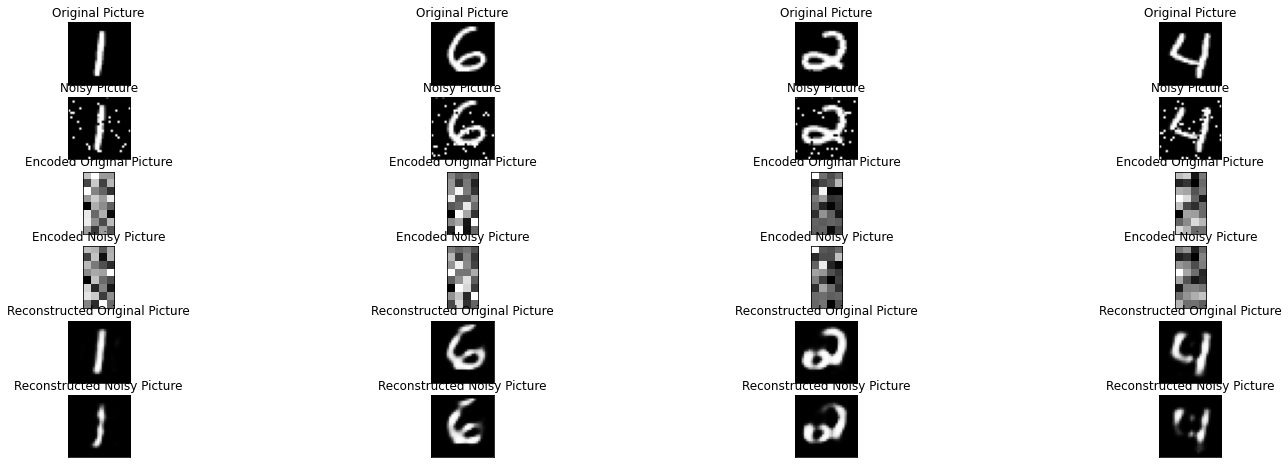

In [ ]:
#Same method as the plot of the compressed images in Section 4.1
#4 were asked to be plotted.

num_images = 4
np.random.seed(42)
random_test_images_noise = np.random.randint(x_test.shape[0], size=num_images)
noise_xtest=random_noise(x_test, mode='s&p',amount =0.1)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)
encoded_imgs_noise = encoder.predict(noise_xtest)
decoded_imgs_noise = autoencoder.predict(noise_xtest)

plt.figure(figsize=(25, 8))

for i, image_idx in enumerate(random_test_images_noise):
    # plot original image
    ax = plt.subplot(6, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Original Picture')
    
    #plot noisy images
    ax = plt.subplot(6, num_images,num_images+ i + 1)
    plt.imshow(noise_xtest[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    plt.title('Noisy Picture')
    
    # plot encoded image
    ax = plt.subplot(6, num_images, 2*num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Encoded Original Picture')
    
    
    # plot encoded noisy image
    ax = plt.subplot(6, num_images, 3*num_images + i + 1)
    plt.imshow(encoded_imgs_noise[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Encoded Noisy Picture')
    
    # plot reconstructed image
    ax = plt.subplot(6, num_images, 4*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Reconstructed Original Picture')    

    # plot reconstructed noisy image
    ax = plt.subplot(6, num_images, 5*num_images + i + 1)
    plt.imshow(decoded_imgs_noise[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Reconstructed Noisy Picture')    

   
plt.show()

For this level of noise, it can be seen that the auto encoder is still doing a fair job in decoding noisy pictures.
Let's investigate what noise level is preventing the user and the autoencoder to understand what digits is shown.

In [ ]:
#Creation of different levels of noisy data
noise_level= [0.1*i for i in range(11)]

#Creation of the noisy data and prediction
all_noise_x_test=[]
all_noise_decoded = []
for i in range(len(noise_level)):
    noisy_images=random_noise(x_test, mode='s&p',amount =noise_level[i])
    all_noise_x_test.append(noisy_images)
    all_noise_decoded.append(autoencoder.predict(noisy_images))


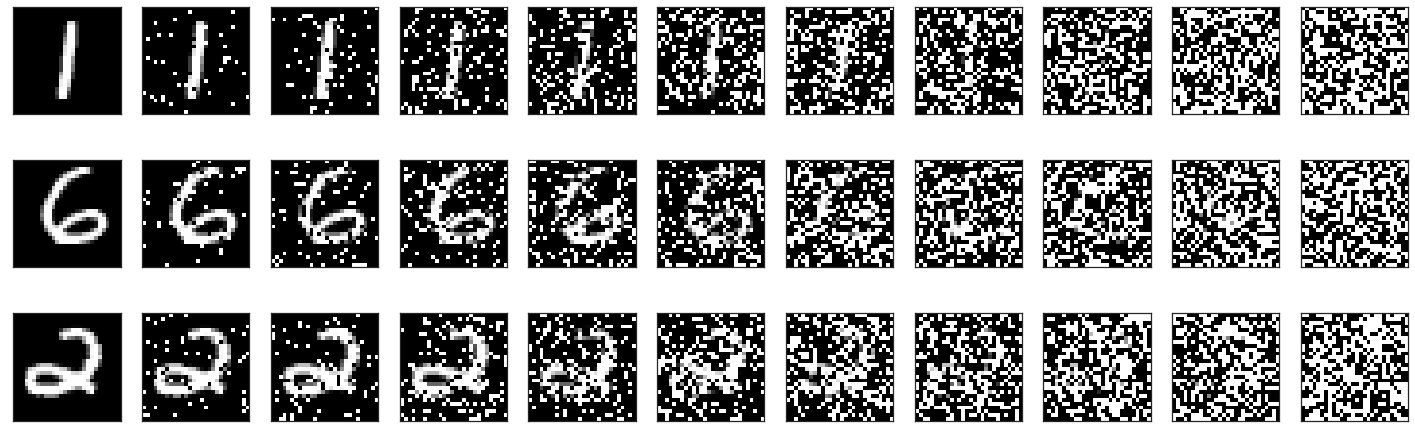

In [ ]:
#Plotting the different levels of noises

num_images = 3
np.random.seed(42)
random_test_images_noise = np.random.randint(x_test.shape[0], size=num_images)

plt.figure(figsize=(25, 8))

for j, image_idx in enumerate(random_test_images_noise):
    for i in range(len(all_noise_x_test)):
        ax = plt.subplot(num_images, len(all_noise_x_test),len(all_noise_x_test)*j+i+1)
        plt.imshow(all_noise_x_test[i][image_idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    
plt.show()

The pictures show noises ranging from 0% to 100%. From the user's perspective, it started to be hard for us to identify digits starting from 40%-50%.

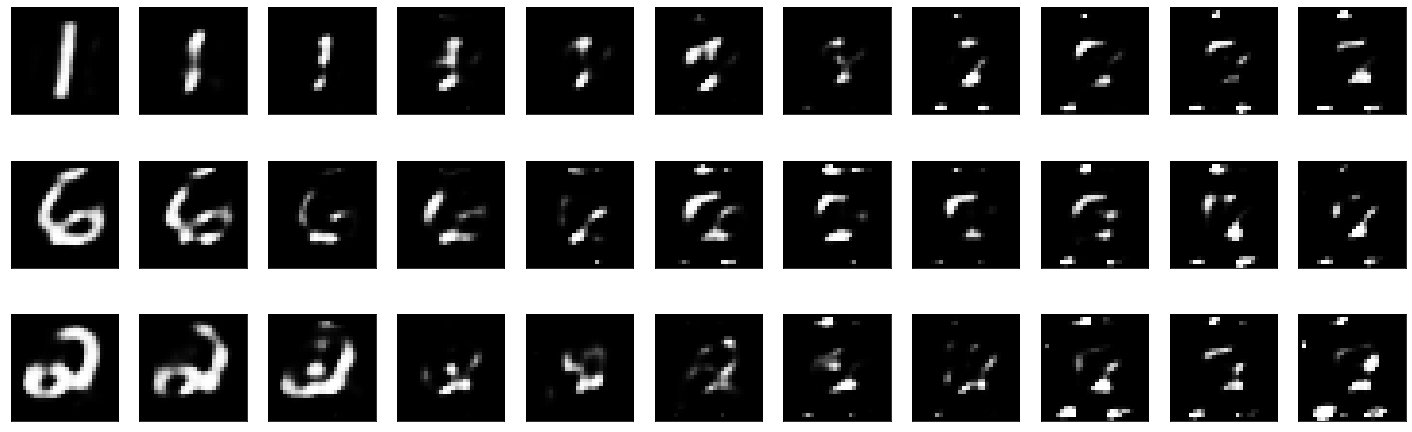

In [ ]:
#Plotting the different levels of decoded pictures

num_images = 3
np.random.seed(42)
random_test_images_noise = np.random.randint(x_test.shape[0], size=num_images)

plt.figure(figsize=(25, 8))

for j, image_idx in enumerate(random_test_images_noise):
    for i in range(len(all_noise_x_test)):
        ax = plt.subplot(num_images, len(all_noise_decoded),len(all_noise_decoded)*j+i+1)
        plt.imshow(all_noise_decoded[i][image_idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
   
plt.show()

Regarding the decoding of the noisy images, the outputs start to become undereadable around 20-30% noise.

## 4C: Classification improvement with denoiser

The idea of this section is to classify properly the digits dataset after the dataset have been denoised with the previous denoiser.
A plot of the accuracy with the seasoned data vs the noise level and the denoised data vs the noise level will be done.

In [ ]:
# Computing the results of the classification 
#without denoising

accuracy_noisy=[]
print("Classification results without denoising")
for i in range(len(all_noise_x_test)):
    score = best_model.evaluate(all_noise_x_test[i], y_test, verbose=0)
    accuracy_noisy.append(score[1])

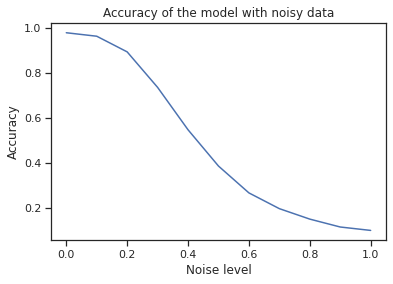

In [ ]:
# Things to plot
plt.plot(noise_level,accuracy_noisy)

# Labels, title and legend
plt.title('Accuracy of the model with noisy data')
plt.ylabel('Accuracy')
plt.xlabel('Noise level')

# Plotting
plt.show()

Similarly as the user ability to identify proper noised digits, the accuracy starts to decrease significantly after 30% 

In [ ]:
# Computing the results of the classification 
#after denoising

accuracy_denoised=[]
print("Classification results after denoising")
for i in range(len(all_noise_decoded)):
    score = best_model.evaluate(all_noise_decoded[i], y_test, verbose=0)
    accuracy_denoised.append(score[1])

Classification results after denoising
Test loss: 0.1223, Test accuracy 0.9664,Noise 0.0000
Test loss: 0.5055, Test accuracy 0.8562,Noise 10.0000
Test loss: 1.3963, Test accuracy 0.6413,Noise 20.0000
Test loss: 2.3315, Test accuracy 0.4409,Noise 30.0000
Test loss: 3.0078, Test accuracy 0.3138,Noise 40.0000
Test loss: 3.3589, Test accuracy 0.2312,Noise 50.0000
Test loss: 3.5511, Test accuracy 0.1912,Noise 60.0000
Test loss: 3.7055, Test accuracy 0.1541,Noise 70.0000
Test loss: 3.7393, Test accuracy 0.1313,Noise 80.0000
Test loss: 3.7821, Test accuracy 0.1172,Noise 90.0000
Test loss: 3.8433, Test accuracy 0.0949,Noise 100.0000


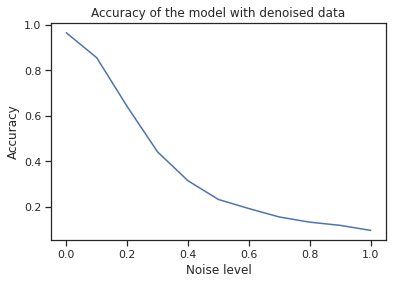

In [ ]:
# Things to plot

plt.plot(noise_level,accuracy_denoised)

# Labels, title and legend
plt.title('Accuracy of the model with denoised data')
plt.ylabel('Accuracy')
plt.xlabel('Noise level')

# Plotting
plt.show()

The accuracy here starts also to decrease significantly in the same way as the user ability to idenitfy: around 20%.

In other words, the loss of information provided by the denoiser is preventing the model to predict precisely the value of the noisy digits.
However, this might be due to the fact that the autoencoder is only having one internal layer. Deep learning with more layers might help the model reducing the dimensions to better understand the outliers and so identify the denoised picture 

## 4D: Synthetic "hand-written" digits synthesis

The decoder part of the denoising function can be used to generate synthetic "hand-written" digits by inputing generated encoded digits that are then decoded as hand-written digits.
A common method to do it is by implementing a Variational AutoEncoder. In fact, the model will train an encoder that will built a probability distribution from the inputs that will then be able to encode any inputs from the latent space, that will then be exported as hand-written digits by the decoder. 
The implementation will be based on the AutoEncoders shown in the material of Module 7. 

In [3]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [5]:
from tensorflow.keras import layers

The sampling function below will help create data from the latent space.

In [6]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [8]:
# Create encoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

The two loss-functions (the sum of a reconstruction term, and the KL divergence regularization term) will train the model.

In [11]:
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

The model can be trained.

In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=30,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/30
1875/1875 [==============================] - 22s 12ms/step - loss: 158.1667 - val_loss: 157.6709
Epoch 2/30
1875/1875 [==============================] - 22s 12ms/step - loss: 156.9188 - val_loss: 156.7619
Epoch 3/30
1875/1875 [==============================] - 22s 12ms/step - loss: 155.8518 - val_loss: 155.7195
Epoch 4/30
1875/1875 [==============================] - 22s 11ms/step - loss: 154.9740 - val_loss: 154.8188
Epoch 5/30
1875/1875 [==============================] - 22s 12ms/step - loss: 154.2116 - val_loss: 154.0937
Epoch 6/30
1875/1875 [==============================] - 24s 13ms/step - loss: 153.5591 - val_loss: 153.6365
Epoch 7/30
1875/1875 [==============================] - 24s 13ms/step - loss: 153.0140 - val_loss: 153.0925
Epoch 8/30
1875/1875 [==============================] - 25s 13ms/step - loss: 152.4947 - val_loss: 152.7023
Epoch 9/30
1875/1875 [==============================] - 25s 13ms/step - loss: 152.0612 - val_loss: 152.4741
Epoch 10/30
1875/1875 [=====

Now that the model is trained, we can now give inputs from the latent space that will gie us some hand-written digits.

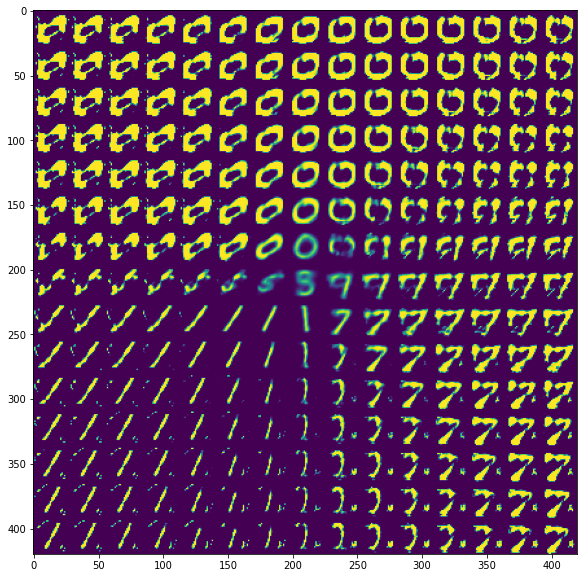

In [19]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

As can be seen, look-alike hand-written digits are created by the model. Increasing the number of epochs and working on the different layers of the VAE might help having better digits.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d21e6fd7-4bb5-4a51-8275-24a3582ee5b9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>